- include pdf of analysis once done
- duplicate and make week_4.ipynb with visuals i actually used

In [2]:
# all imports

import pyarrow.csv as pv
import pyarrow.parquet as pq
import pyarrow as pa
import polars as pl

In [ ]:
# preprocessing function (polars)

csv_file = "2022_place_canvas_history.csv"
parquet_file = "2022pyarrow.parquet"

DATESTRING_FORMAT = "%Y-%m-%d %H:%M:%S"
BLOCK_SIZE = 100_000_000

read_options = pv.ReadOptions(block_size=BLOCK_SIZE)
csv_reader = pv.open_csv(csv_file, read_options=read_options)

parquet_writer = None

try:
    for record_batch in csv_reader:
        print(f"Processing batch with {record_batch.num_rows} rows...")

        df = pl.from_arrow(record_batch)

        # convert timstamp to datetime object
        df = df.with_columns(
            pl.col("timestamp")
            .str.replace(r" UTC$", "")  
            .str.strptime(
                pl.Datetime, 
                format="%Y-%m-%d %H:%M:%S%.f",
                strict=False
            )
            .alias("timestamp")
        )

        # split coordinate into cols 'x', 'y' 
        df = (
            df.filter(
                pl.col("coordinate").str.count_matches(",") == 1
            )
            .with_columns(
                pl.col("coordinate")
                .str.split_exact(",", 1)
                .struct.field("field_0")
                .cast(pl.Int64)
                .alias("x"),
                pl.col("coordinate")
                .str.split_exact(",", 1)
                .struct.field("field_1")
                .cast(pl.Int64)
                .alias("y"),
            )
            .drop("coordinate")
            )

        # map user_id to ints to save memory
        df = df.with_columns(
            pl.col('user_id')
            .cast(pl.Categorical)  # convert to categorical (assigns unique codes)
            .to_physical()         # get int rep
            .alias('user_id_int')
        )
        df = df.drop("user_id") # can drop user_id now

        table = df.to_arrow()

        if parquet_writer is None:
            parquet_writer = pq.ParquetWriter(
                parquet_file, 
                schema=table.schema, 
                compression="zstd"
            )
        parquet_writer.write_table(table)

finally:
    if parquet_writer:
        parquet_writer.close()

print(f"Successfully converted {csv_file} to {parquet_file}")

In [3]:
parquet_file = pq.ParquetFile("2022pyarrow.parquet")

row_count = parquet_file.metadata.num_rows
columns = parquet_file.schema.names

print(f"Number of rows: {row_count}")
print(f"Columns: {columns}")
# and parquet is 1.45 GB

Number of rows: 160353085
Columns: ['timestamp', 'pixel_color', 'x', 'y', 'user_id_int']


In [ ]:
# can retrieve original user_id with: 

# df.with_columns(
#     pl.col('user_id_int')
#     .reverse()
#     .alias('user_id')
# )

# What are the top 3 most painted pixels?

In [26]:
parquet_file = "2022pyarrow.parquet"

lf = pl.scan_parquet(parquet_file)  # LazyFrame (efficient for big data)
lf.collect().head()

timestamp,pixel_color,x,y,user_id_int
datetime[μs],str,i64,i64,u32
2022-04-04 00:53:51.577,"""#00CCC0""",826,1048,0
2022-04-04 00:53:53.758,"""#94B3FF""",583,1031,1
2022-04-04 00:53:54.685,"""#6A5CFF""",1873,558,2
2022-04-04 00:54:57.541,"""#009EAA""",1627,255,3
2022-04-04 00:55:16.307,"""#94B3FF""",49,1478,4


In [8]:
top3_paint_counts = (
    lf.group_by(['x', 'y'])
    .agg(pl.len().alias('count')) # count occurances
    .sort('count', descending=True) # sort by count
    .limit(3) # top 3 pixels
)

top3_paint_counts.collect()

x,y,count
i64,i64,u32
0,0,98807
359,564,69198
349,564,55230


The top 3 painted pixels are at locations
1. (0, 0) painted 98807 times
2. (359, 564) painted 69198 times
3. (349, 564) painted 55230 times 

"The 2022 edition started with the same size and colors as 2017, but the canvas was later expanded to four million (2000 x 2000) pixel squares, and the palette gradually gained sixteen more colors for a total of 32."

- (0, 0) is located at the upper left corner of the canvas
- x move to right
- y move down

# Simple EDA: Why were the 3 most painted pixels hit so often?

## 1. Visualize positioning of pixels?
- distribution of count of painted pixels (entire count?)
- maybe visualization of concentration of how often pixels painted on entire canvas?
- were pixels near the top painted pixels, also hit pretty often?

In [6]:
paint_counts = (
    lf.group_by(['x', 'y'])
    .agg(pl.len().alias('count')) # count occurances
    .sort('count', descending=True) # sort by count
)

paint_counts.collect().head(10)

x,y,count
i64,i64,u32
0,0,98807
359,564,69198
349,564,55230
859,766,52261
860,766,51485
104,768,38086
105,768,34082
1999,1999,31437
1999,0,30882


^^ see some clustering in pairs

### Visualize with Heatmap

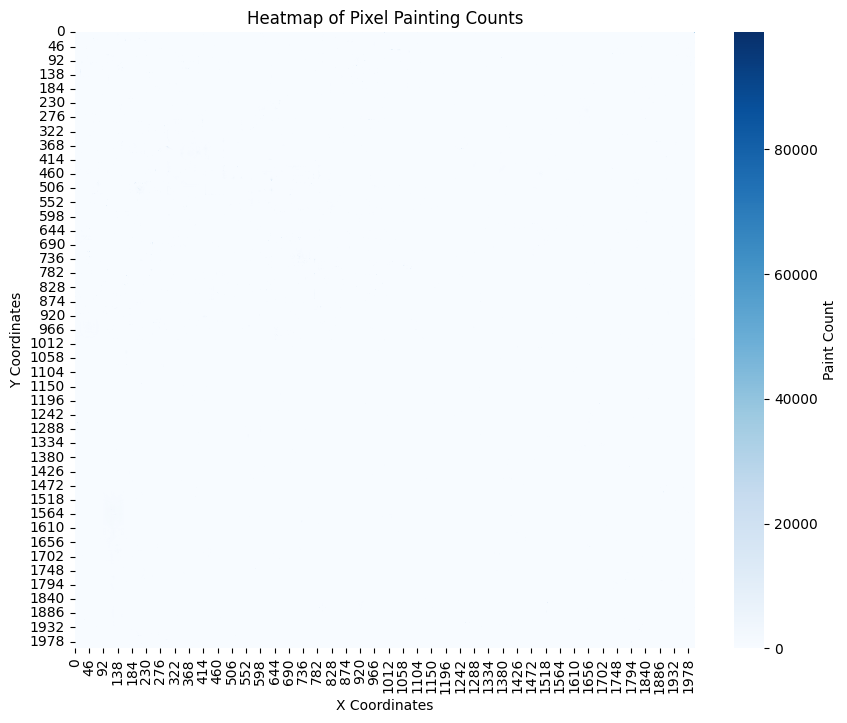

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

paint_counts_pd = paint_counts.collect().to_pandas() # need to convert to pandas to plot

heatmap_data = paint_counts_pd.pivot(index='y', columns='x', values='count').fillna(0) # define heatmap, pivot for grid-like structure

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, fmt='g', cbar_kws={'label': 'Paint Count'})
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

^^ can't see each pixel since range of pixel counts is really high (0 - 97k)

Try by zooming in -> split into 4 sections (top left, bottom left, top right, bottom right) with smaller range of pixel counts

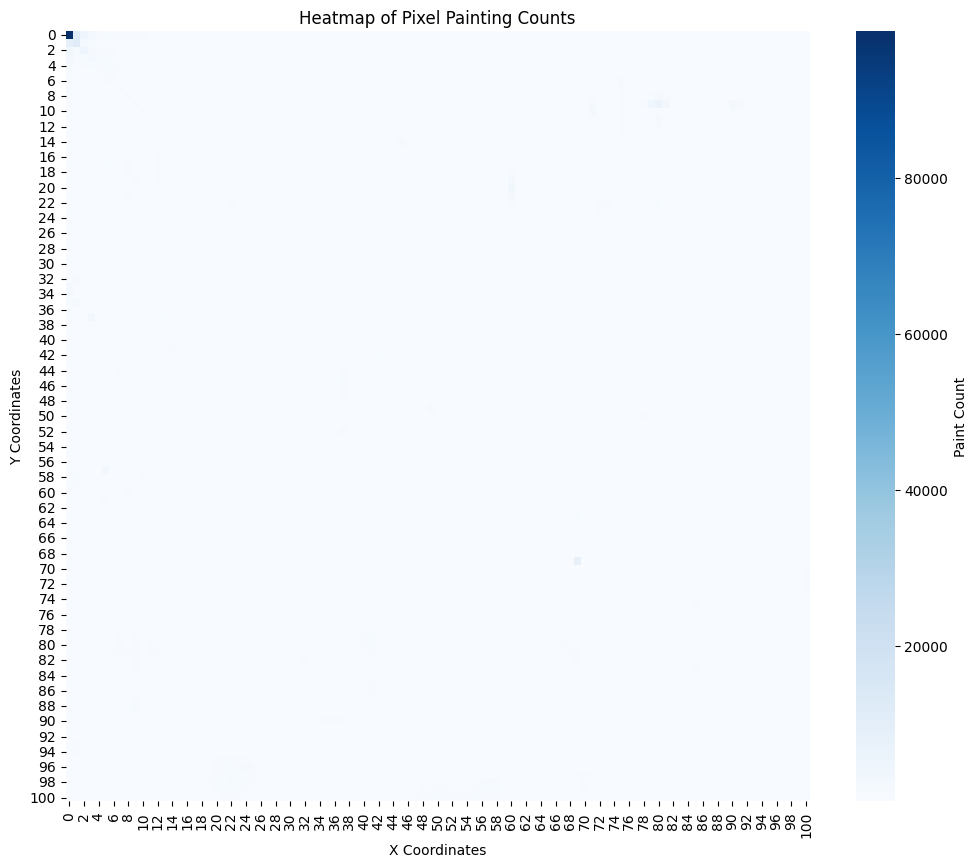

In [58]:
# try heatmap again (with fixes)

plt.figure(figsize=(12, 10))  # increase plot size
sns.heatmap(heatmap_data.loc[0:100, 0:100], cmap='Blues', annot=False, fmt='g', # try zooming in
            cbar_kws={'label': 'Paint Count'}) 

 
# plt.gca().invert_yaxis() # somehow put plot in top left corner
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# This plot shows top left section of canvas (0:100, 0:100).

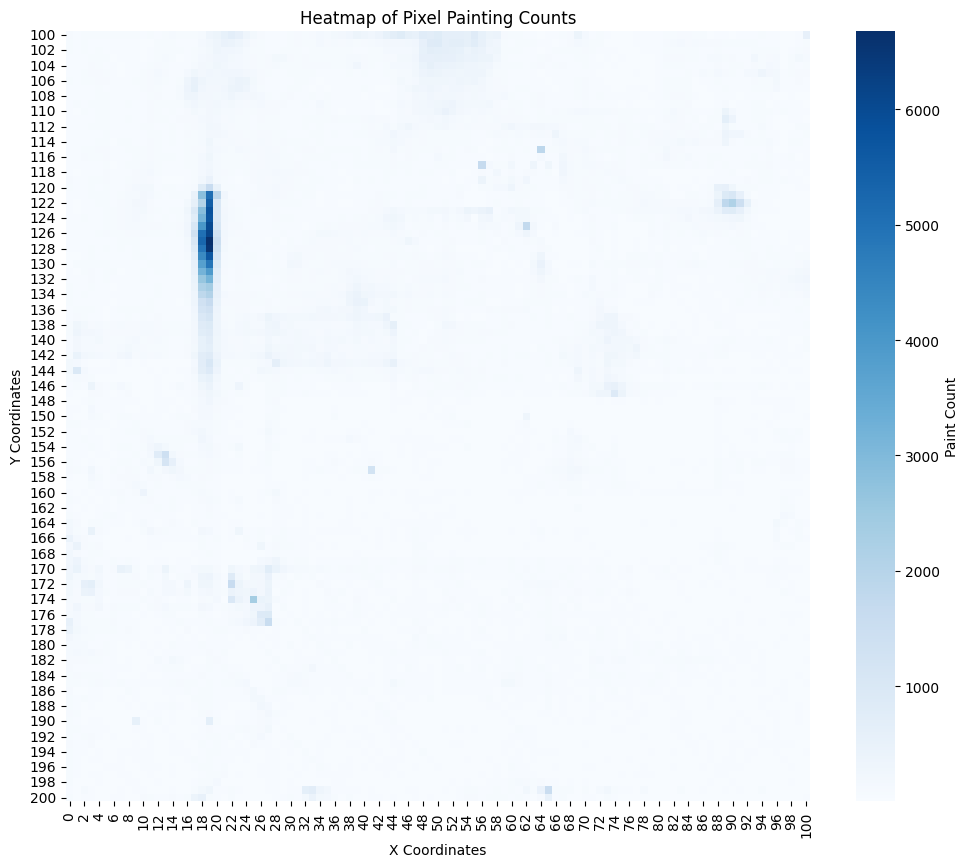

In [60]:
plt.figure(figsize=(12, 10))  # increase plot size
sns.heatmap(heatmap_data.loc[100:200, 0:100], cmap='Blues', annot=False, fmt='g', # try zooming in
            cbar_kws={'label': 'Paint Count'}) 

 
# plt.gca().invert_yaxis() # somehow put plot in top left corner
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# This plot shows top right section of canvas (0:100, 0:100).

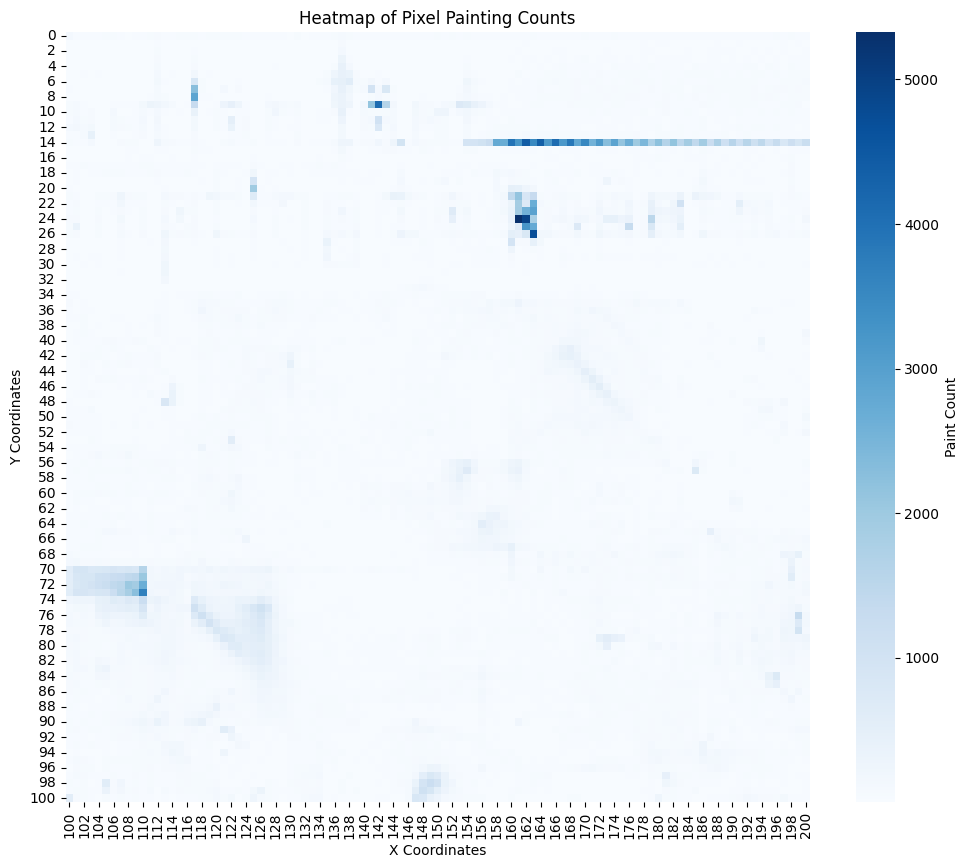

In [43]:
plt.figure(figsize=(12, 10))  # increase plot size
sns.heatmap(heatmap_data.loc[0:100, 100:200], cmap='Blues', annot=False, fmt='g', # try zooming in
            cbar_kws={'label': 'Paint Count'}) 

 
# plt.gca().invert_yaxis() # somehow put plot in top left corner
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# This plot shows bottom left section of canvas (0:100, 100:200).

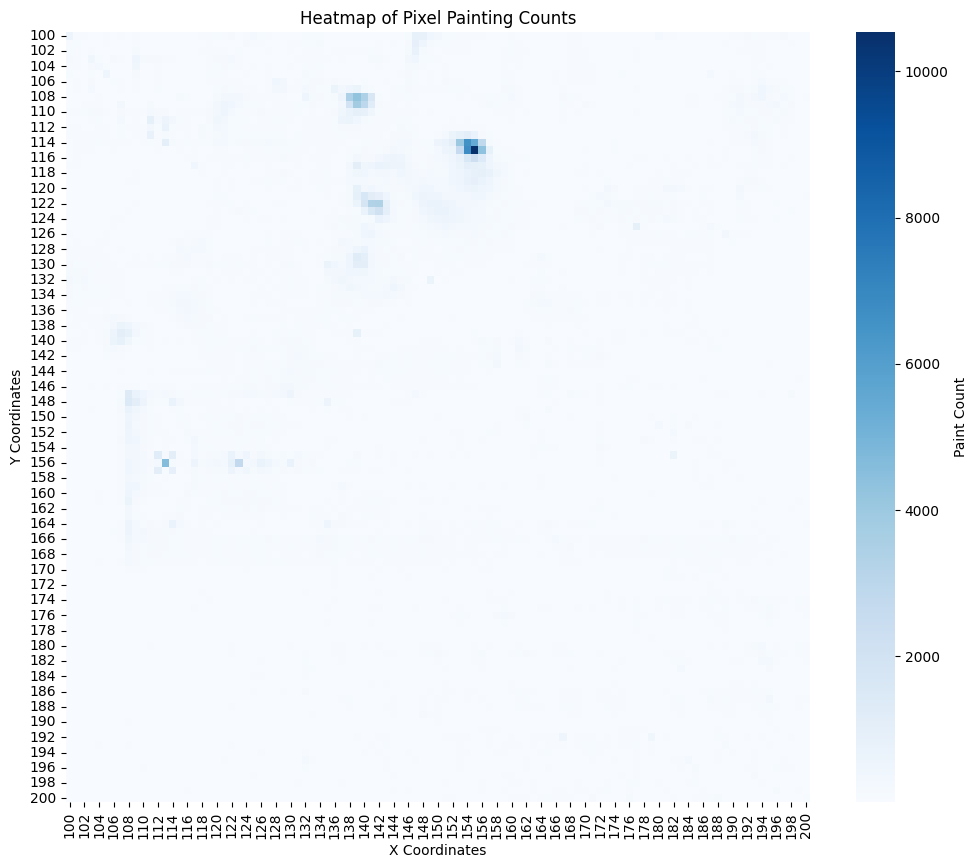

In [44]:
plt.figure(figsize=(12, 10))  # increase plot size
sns.heatmap(heatmap_data.loc[100:200, 100:200], cmap='Blues', annot=False, fmt='g', # try zooming in
            cbar_kws={'label': 'Paint Count'}) 

 
# plt.gca().invert_yaxis() # somehow put plot in top left corner
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# This plot shows bottom right section of canvas (100:200, 100:200).

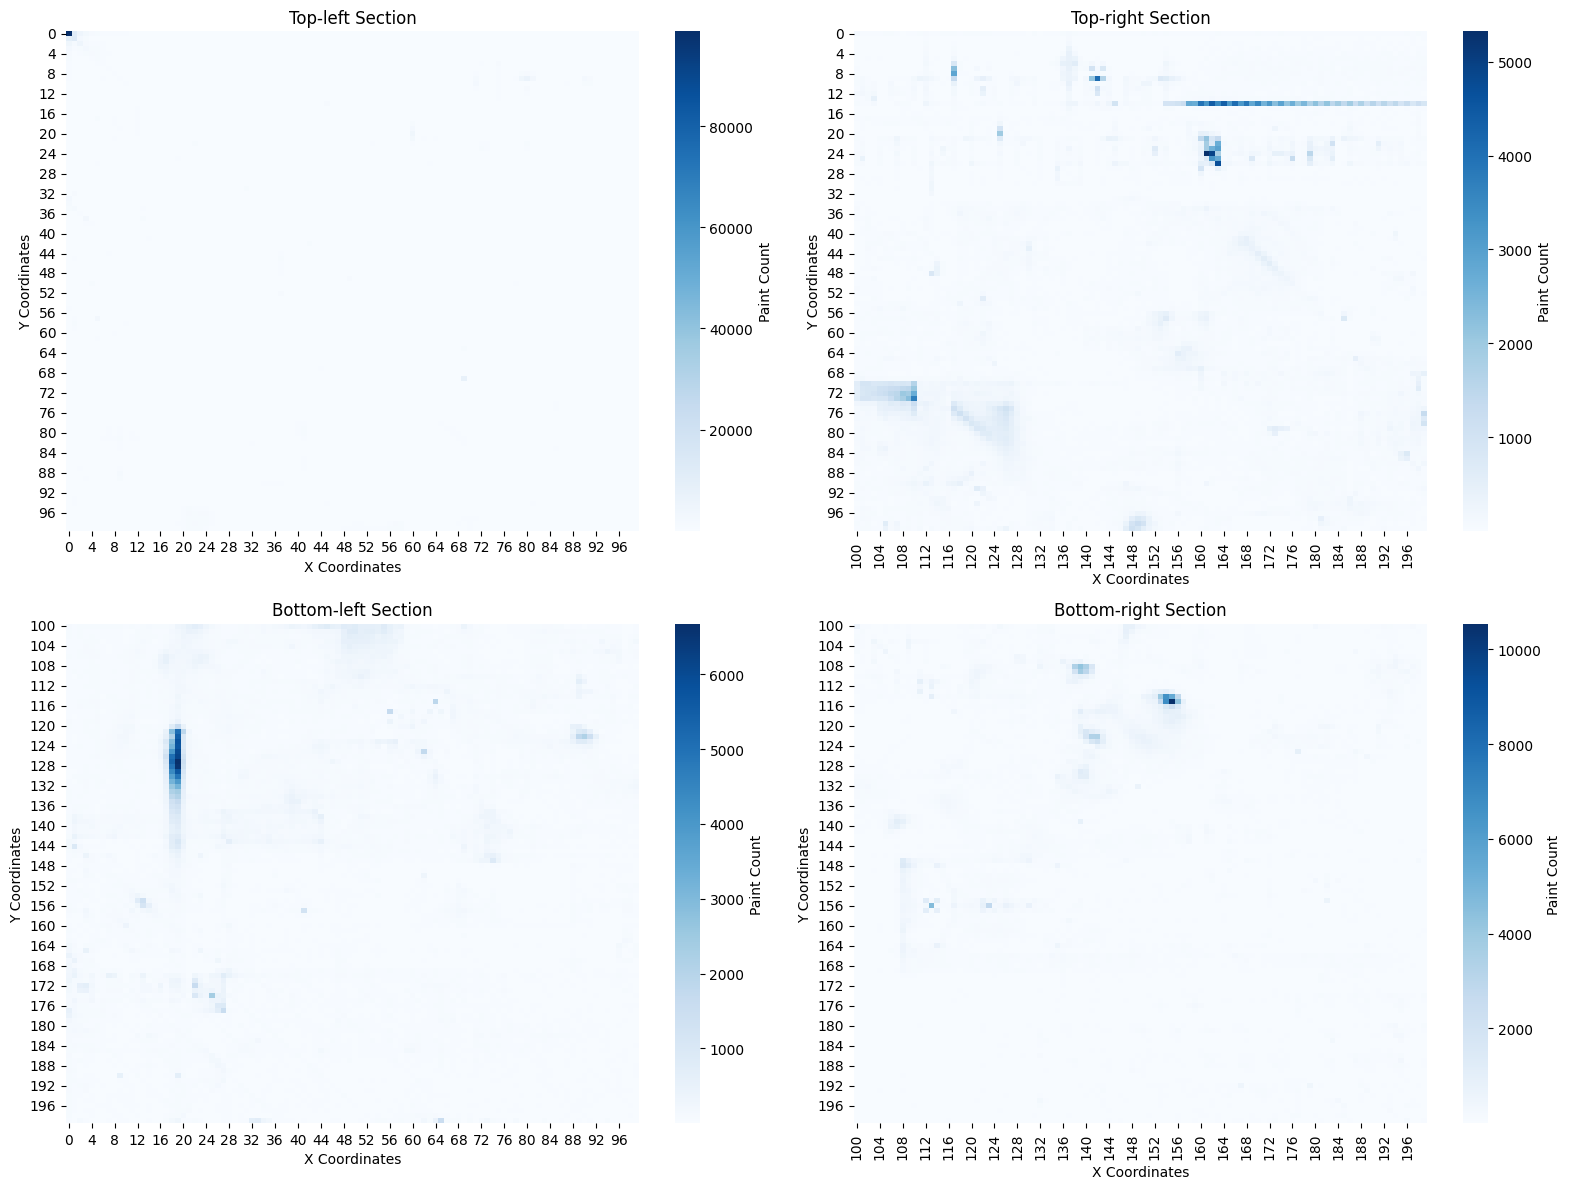

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # 2 rows, 2 cols for 4 sections

# Top-left section (Y: 0-100, X: 0-100)
sns.heatmap(heatmap_data.iloc[0:100, 0:100], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Paint Count'}, ax=axs[0, 0])
axs[0, 0].set_title('Top-left Section')
axs[0, 0].set_xlabel('X Coordinates')  # Columns
axs[0, 0].set_ylabel('Y Coordinates')  # Rows

# Top-right section (Y: 0-100, X: 100-200)
sns.heatmap(heatmap_data.iloc[0:100, 100:200], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Paint Count'}, ax=axs[0, 1])
axs[0, 1].set_title('Top-right Section')
axs[0, 1].set_xlabel('X Coordinates')
axs[0, 1].set_ylabel('Y Coordinates')

# Bottom-left section (Y: 100-200, X: 0-100)
sns.heatmap(heatmap_data.iloc[100:200, 0:100], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Paint Count'}, ax=axs[1, 0])
axs[1, 0].set_title('Bottom-left Section')
axs[1, 0].set_xlabel('X Coordinates')
axs[1, 0].set_ylabel('Y Coordinates')

# Bottom-right section (Y: 100-200, X: 100-200)
sns.heatmap(heatmap_data.iloc[100:200, 100:200], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Paint Count'}, ax=axs[1, 1])
axs[1, 1].set_title('Bottom-right Section')
axs[1, 1].set_xlabel('X Coordinates')
axs[1, 1].set_ylabel('Y Coordinates')

plt.tight_layout()
plt.show()

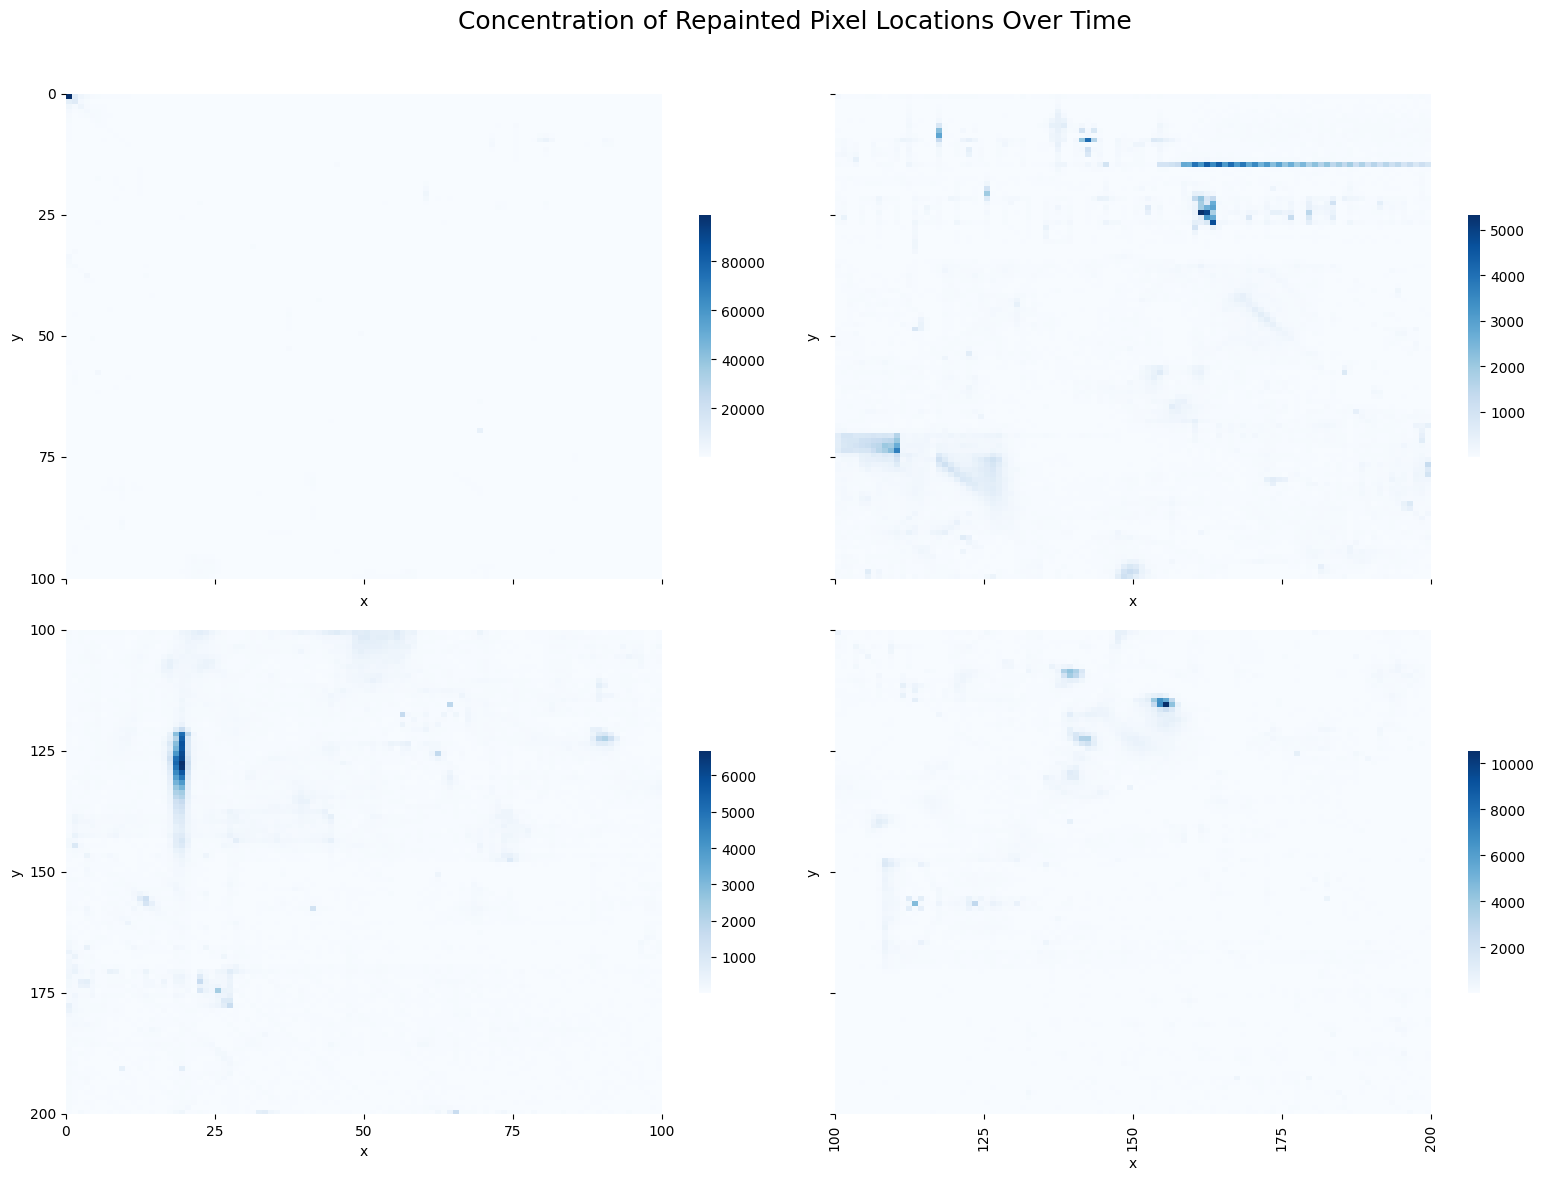

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

sections = [
    (0, 100, 0, 100, "Top-left Section"),
    (0, 100, 100, 200, "Top-right Section"),
    (100, 200, 0, 100, "Bottom-left Section"),
    (100, 200, 100, 200, "Bottom-right Section")
]

for ax, (y_start, y_end, x_start, x_end, title) in zip(axs.flat, sections):
    sns.heatmap(heatmap_data.iloc[y_start:y_end, x_start:x_end], 
                cmap='Blues', annot=False, fmt='g', ax=ax, 
                cbar_kws={"shrink": 0.5})  # adjust color bar size
    
    # ax.set_title(title)

    # set ticks from 0 to 100 by 25
    ax.set_xticks(np.arange(0, 101, 25))  # x-axis ticks every 25
    ax.set_xticklabels(np.arange(x_start, x_end + 1, 25))  # adjust to actual coordinates
    
    ax.set_yticks(np.arange(0, 101, 25))  # y-axis ticks every 25
    ax.set_yticklabels(np.arange(y_start, y_end + 1, 25))  # adjust to actual coordinates

# remove redundant ticks
for ax in axs[0, :]:  # remove x-axis ticks for top row
    ax.set_xticklabels([])
for ax in axs[:, 1]:  # remove y-axis ticks for right col
    ax.set_yticklabels([])

# Add overall title
fig.suptitle("Concentration of Repainted Pixel Locations Over Time", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # adjust to fit title
plt.show()


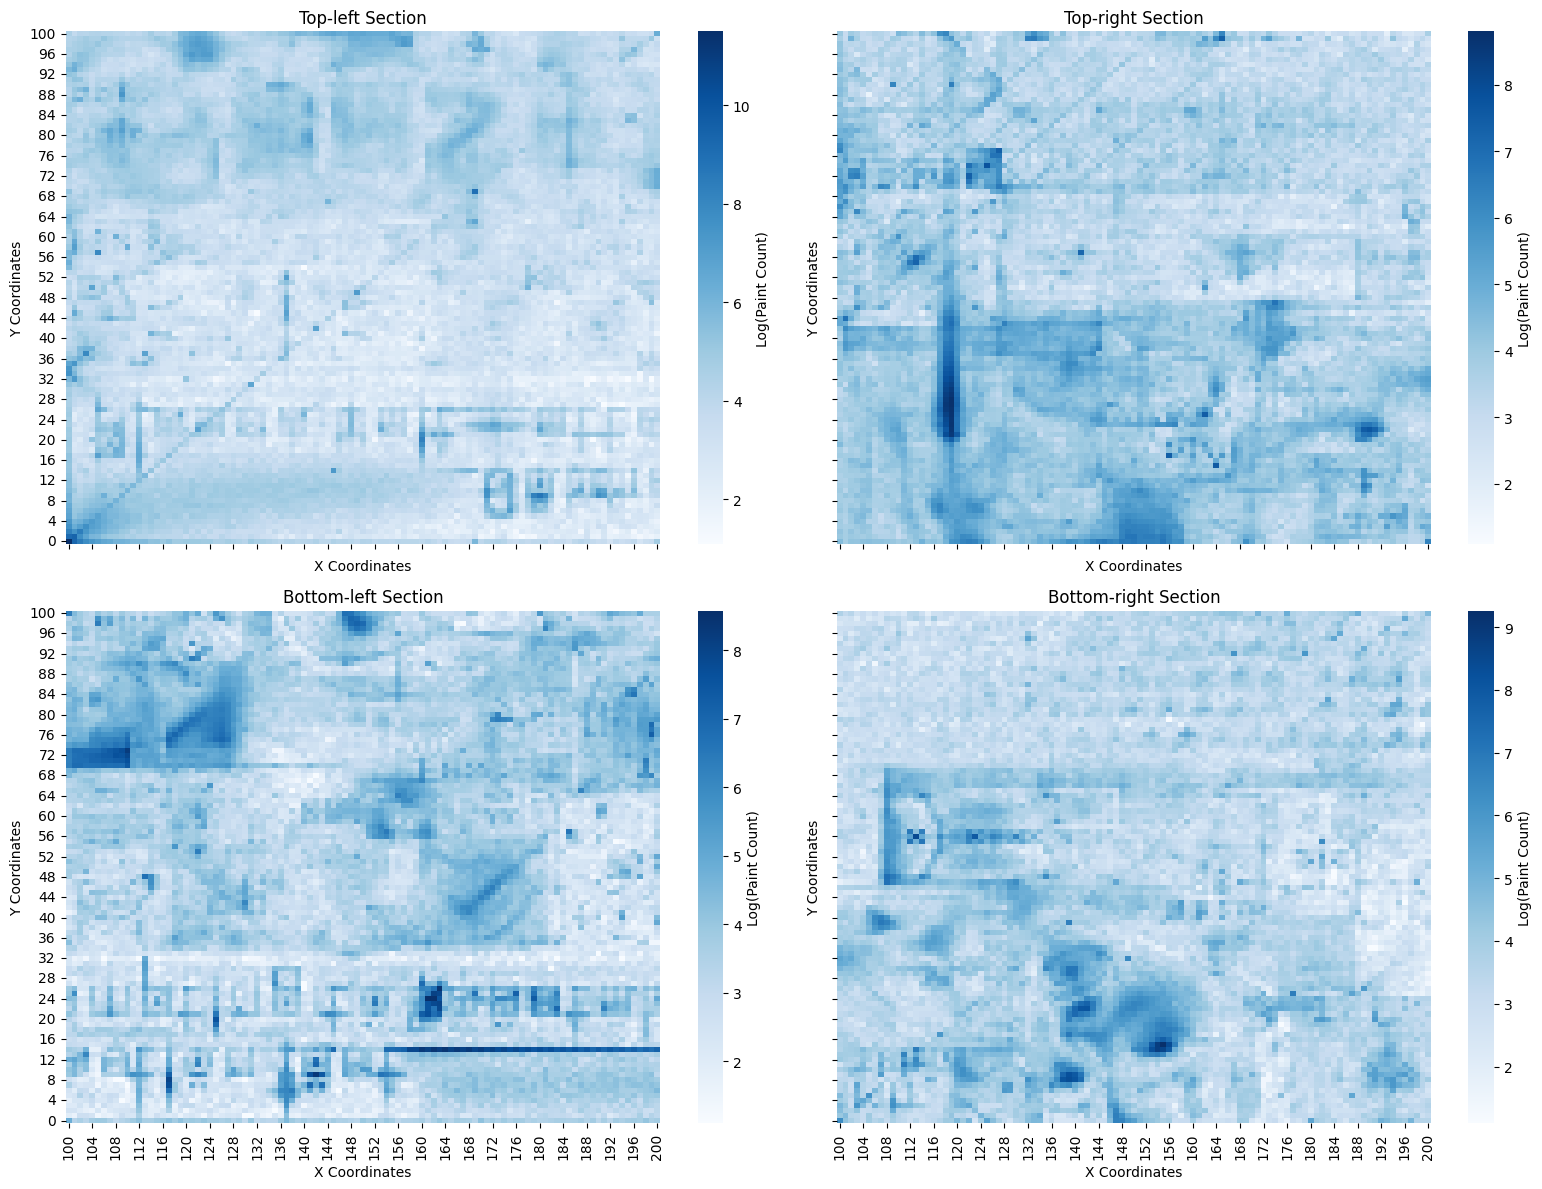

In [ ]:
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# try log scale to normalize different scales?
log_heatmap_data = np.log1p(heatmap_data)  # apply log transformation (log(x+1))

# Top-left section (0:100, 0:100)
sns.heatmap(log_heatmap_data.loc[0:100, 0:100], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Log(Paint Count)'}, ax=axs[0, 0])
axs[0, 0].invert_yaxis()  # Flip y-axis
axs[0, 0].set_title('Top-left Section')
axs[0, 0].set_xlabel('X Coordinates')
axs[0, 0].set_ylabel('Y Coordinates')

# Top-right section (100:200, 0:100)
sns.heatmap(log_heatmap_data.loc[100:200, 0:100], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Log(Paint Count)'}, ax=axs[0, 1])
axs[0, 1].invert_yaxis()  # Flip y-axis
axs[0, 1].set_title('Top-right Section')
axs[0, 1].set_xlabel('X Coordinates')
axs[0, 1].set_ylabel('Y Coordinates')

# Remove x-axis labels for the top-left and top-right plots
axs[0, 0].set_xticklabels([])  # Top-left
axs[0, 1].set_xticklabels([])  # Top-right

# Bottom-left section (0:100, 100:200)
sns.heatmap(log_heatmap_data.loc[0:100, 100:200], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Log(Paint Count)'}, ax=axs[1, 0])
axs[1, 0].invert_yaxis()  # Flip y-axis
axs[1, 0].set_title('Bottom-left Section')
axs[1, 0].set_xlabel('X Coordinates')
axs[1, 0].set_ylabel('Y Coordinates')

# Bottom-right section (100:200, 100:200)
sns.heatmap(log_heatmap_data.loc[100:200, 100:200], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Log(Paint Count)'}, ax=axs[1, 1])
axs[1, 1].invert_yaxis()  # Flip y-axis
axs[1, 1].set_title('Bottom-right Section')
axs[1, 1].set_xlabel('X Coordinates')
axs[1, 1].set_ylabel('Y Coordinates')

# Remove y-axis labels for the top-right and bottom-right plots
axs[0, 1].set_yticklabels([])  # Top-right
axs[1, 1].set_yticklabels([])  # Bottom-right

plt.tight_layout()
plt.show()


### Try Visualization with Scatterplot (that behaves like Heatmap)

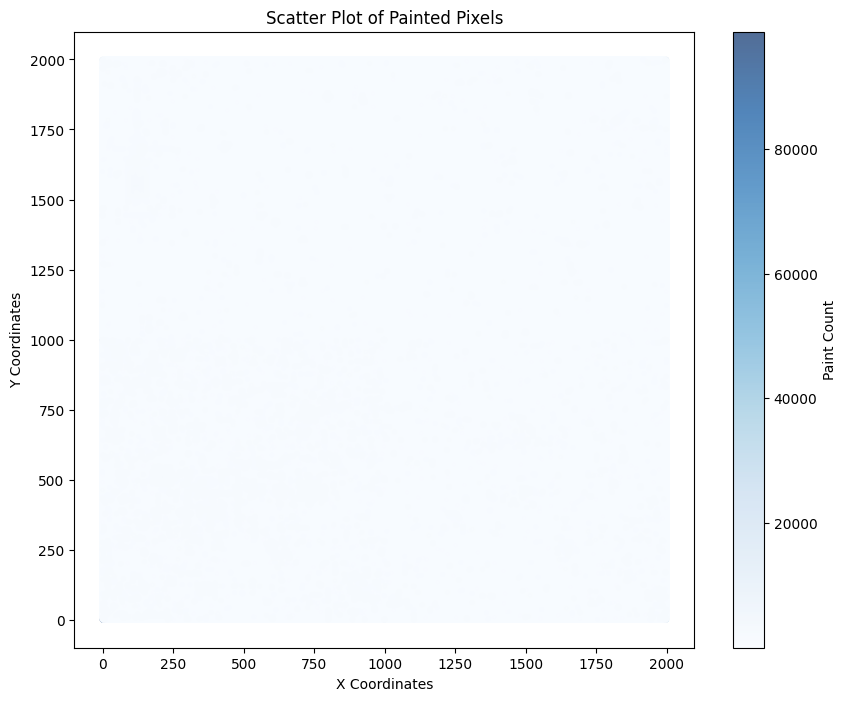

In [57]:
# scatterplot for painted pixels

plt.figure(figsize=(10, 8))
plt.scatter(paint_counts_pd['x'], paint_counts_pd['y'], c=paint_counts_pd['count'], cmap='Blues', s=10, alpha=0.7)
plt.colorbar(label='Paint Count')
plt.title('Scatter Plot of Painted Pixels')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# same challenge as HeatMap

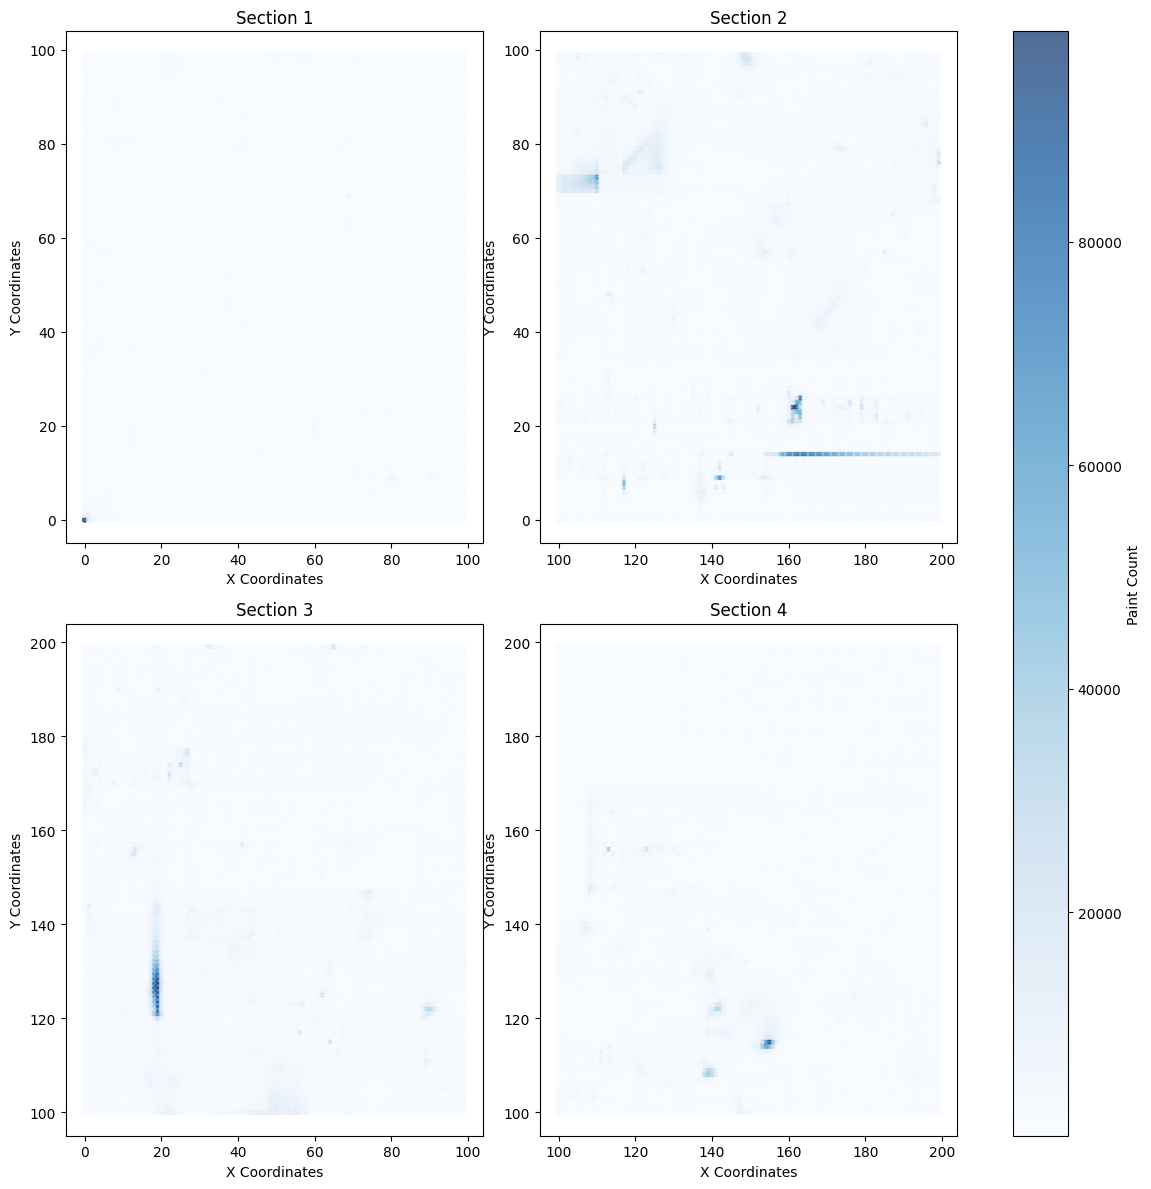

In [ ]:
# plot a section of the canvas
def plot_section(ax, x_min, x_max, y_min, y_max, data, title):

    # filter data to specified section
    section_data = data[(data['x'] >= x_min) & (data['x'] < x_max) & 
                        (data['y'] >= y_min) & (data['y'] < y_max)]
    
    # plot for selected section
    sc = ax.scatter(section_data['x'], section_data['y'], c=section_data['count'], cmap='Blues', s=10, alpha=0.7)
    
    # titles & labels for each subplot
    ax.set_title(title)
    ax.set_xlabel('X Coordinates')
    ax.set_ylabel('Y Coordinates')

    return sc

fig, axes = plt.subplots(2, 2, figsize=(12, 12)) # 2x2 grid for sections

# plot each section in its respective subplot
sc1 = plot_section(axes[0, 0], 0, 100, 0, 100, paint_counts_pd, 'Section 1')
sc2 = plot_section(axes[0, 1], 100, 200, 0, 100, paint_counts_pd, 'Section 2')
sc3 = plot_section(axes[1, 0], 0, 100, 100, 200, paint_counts_pd, 'Section 3')
sc4 = plot_section(axes[1, 1], 100, 200, 100, 200, paint_counts_pd, 'Section 4')

plt.tight_layout()
fig.colorbar(sc1, ax=axes, orientation='vertical', label='Paint Count') # color bar
plt.show()


## 2. Look at colors
- what different colors were painted on the top 3 pixels?
- what are top colors for entire dataset?

In [ ]:
# top3_pixel_colors = (
#     lf.filter(
#         ((pl.col('x') == 0) & (pl.col('y') == 0)) |  # (x=0, y=0)
#         ((pl.col('x') == 359) & (pl.col('y') == 564)) |  # (x=359, y=564)
#         ((pl.col('x') == 349) & (pl.col('y') == 564))  # (x=349, y=564)
#     ) # filter top 3 pixels
#     .group_by(['x', 'y', 'pixel_color'])
#     .agg(pl.len().alias('color_count')) # count colors for each x,y
#     .sort(['x', 'y', 'color_count'], descending=[False, False, True])
# )

# top3_pixel_colors.collect() # color counts for each of top 3 pixels

x,y,pixel_color,color_count
i64,i64,str,u32
0,0,"""#FFFFFF""",59282
0,0,"""#000000""",8715
0,0,"""#FF4500""",4209
0,0,"""#811E9F""",2200
0,0,"""#BE0039""",2189
…,…,…,…
359,564,"""#E4ABFF""",34
359,564,"""#00756F""",20
359,564,"""#FFF8B8""",14


- how many colors for each pixel?
- top colors for each pixel?

In [ ]:
# top3_colors_df = (
#     (top3_pixel_colors.collect()) # make it to df
#     .group_by(['x', 'y'])  # Group by (x, y) after sorting
#     .agg(
#         pl.col('pixel_color').head(3).alias('top_3_colors'),  # get top 3 colors for each (x, y)
#         pl.col('color_count').head(3).alias('top_3_counts')  # get counts for these top 3 colors
#     )
# )

# top3_colors_df

x,y,top_3_colors,top_3_counts
i64,i64,list[str],list[u32]
349,564,"[""#000000"", ""#51E9F4"", ""#FF4500""]","[27804, 19404, 2120]"
0,0,"[""#FFFFFF"", ""#000000"", ""#FF4500""]","[59282, 8715, 4209]"
359,564,"[""#000000"", ""#51E9F4"", ""#FF4500""]","[34726, 26940, 1656]"


In [38]:
top3_colors_df = (
    lf.filter(
        ((pl.col('x') == 0) & (pl.col('y') == 0)) |  # (x=0, y=0)
        ((pl.col('x') == 359) & (pl.col('y') == 564)) |  # (x=359, y=564)
        ((pl.col('x') == 349) & (pl.col('y') == 564))  # (x=349, y=564)
    ) 
    .group_by(['x', 'y', 'pixel_color'])  # group by (x, y, pixel_color)
    .agg(pl.len().alias('color_count'))  # count occurrences of each color for each (x, y)
    .sort(['x', 'y', 'color_count'], descending=[False, False, True])  # sort by x, y and color count
    .group_by(['x', 'y'])  # group by (x, y) to aggregate top 3 colors for each pixel
    .agg(
        pl.col('pixel_color').head(3).alias('top_3_colors'),  # Get top 3 colors
        pl.col('color_count').head(3).alias('top_3_counts')  # Get top 3 color counts
    )
)

top3_colors_df.collect()  # Collect the results


x,y,top_3_colors,top_3_counts
i64,i64,list[str],list[u32]
349,564,"[""#000000"", ""#51E9F4"", ""#FF4500""]","[27804, 19404, 2120]"
359,564,"[""#000000"", ""#51E9F4"", ""#FF4500""]","[34726, 26940, 1656]"
0,0,"[""#FFFFFF"", ""#000000"", ""#FF4500""]","[59282, 8715, 4209]"


In [36]:
# top 3 colors for entire data?

top_colors_3 = (
    lf.group_by('pixel_color')  # Group by pixel_color
    .agg(pl.len().alias('color_count'))  # Count occurrences of each color
    .sort('color_count', descending=True)  # Sort by color_count in descending order
    .head(3)
)

top_colors_3.collect()

pixel_color,color_count
str,u32
"""#000000""",33707367
"""#FFFFFF""",32251013
"""#FF4500""",14411389


- white, black, orange/red are top 3 colors
- same as top pixels but light blue seems #6 most common

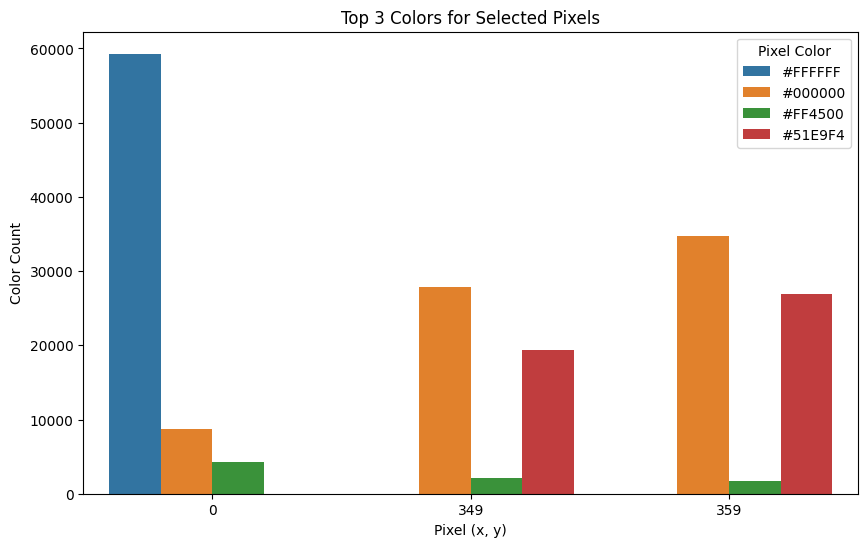

In [46]:
# Convert the top3_colors_df to long format by exploding the lists into individual rows
top3_colors_long_df = top3_colors_df.explode(['top_3_colors', 'top_3_counts'])

# Convert back to a pandas DataFrame for plotting
top3_colors_long_df = top3_colors_long_df.to_pandas()

# Check the result
top3_colors_long_df.head()

import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the bar chart for the top 3 colors at each pixel
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='x', y='top_3_counts', hue='top_3_colors', data=top3_colors_long_df, ax=ax)

ax.set_title('Top 3 Colors for Selected Pixels')
ax.set_xlabel('Pixel (x, y)')
ax.set_ylabel('Color Count')
plt.legend(title='Pixel Color')
plt.show()


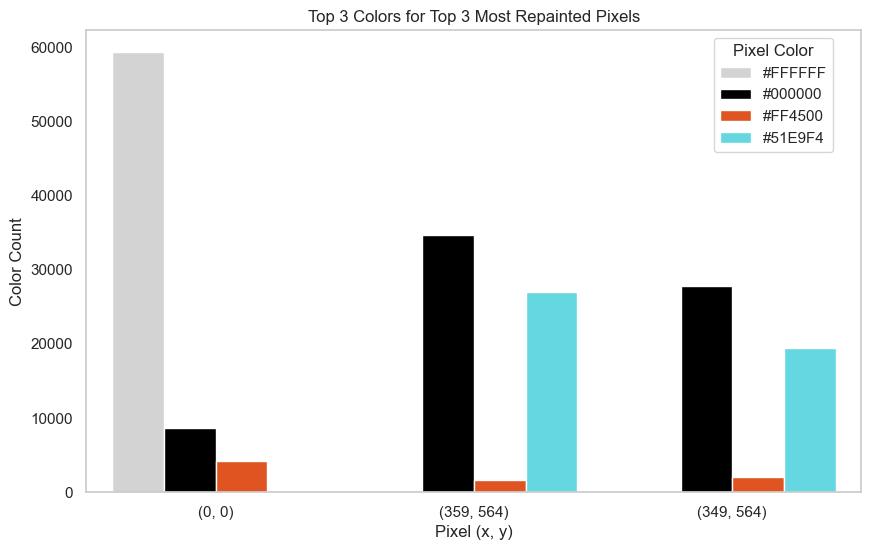

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Convert the top3_colors_df to long format by exploding the lists into individual rows
top3_colors_long_df = top3_colors_df.explode(['top_3_colors', 'top_3_counts'])

# Convert back to a pandas DataFrame for plotting
top3_colors_long_df = top3_colors_long_df.to_pandas()

# Convert pixel coordinates to a string for displaying
top3_colors_long_df['pixel_coordinates'] = '(' + top3_colors_long_df['x'].astype(str) + ', ' + top3_colors_long_df['y'].astype(str) + ')'

# Plotting the bar chart for the top 3 colors at each pixel
fig, ax = plt.subplots(figsize=(10, 6))

# Create the palette dictionary with unique colors
palette = {color: color for color in top3_colors_long_df['top_3_colors'].unique()}

# Plotting with the custom palette
sns.barplot(x='pixel_coordinates', y='top_3_counts', hue='top_3_colors', data=top3_colors_long_df, ax=ax, palette=palette)

# Change the color of the white bars to light gray (#D3D3D3)
for patch in ax.patches:
    if patch.get_facecolor() == (1.0, 1.0, 1.0, 1.0):  # Checking if the color is white (#FFFFFF)
        patch.set_facecolor('#D3D3D3')  # Set the face color to light gray (#D3D3D3)

# Disable the grid lines
ax.grid(False)

# Customize the legend and move it inside
ax.legend(title='Pixel Color', loc='upper left', bbox_to_anchor=(0.8, 1))

# Set the plot title and labels
ax.set_title('Top 3 Colors for Top 3 Most Repainted Pixels')
ax.set_xlabel('Pixel (x, y)')
ax.set_ylabel('Color Count')

# Show the plot
plt.show()


## 3. cont

In [ ]:
# did the highest painted pixels change over time?
    # try specific days, hours, etc.
    # also look up certain events that might have caused this
    # clustering?

In [ ]:
# looking at user traffic, were they painted when lots of users were on the site?
    # being painted over at the same time, etc.?
    # see which users painted the top 3, any repeat users?

# Look at 2022 final canvas and find corresponding pixels
- focus on meme culture, trends, etc.

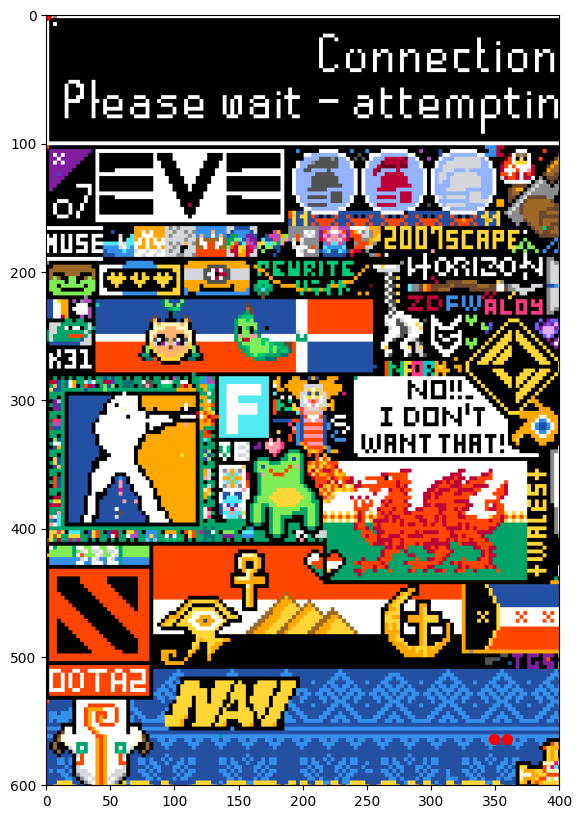

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

canvas = Image.open("2022_canvas_final.png") # load in final r/place 2022 canva

top_pixels = [(0, 0), (359, 564), (349, 564)]  # def most painted pixels

width, height = 400, 600 # zoom into these dim

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

for (x, y) in top_pixels: # mark top pixels
    ax.scatter(x, y, color='red', s=50)

ax.set_xlim(0, width)  
ax.set_ylim(height, 0)  # invert y-axis to align with image coordinates

plt.show()

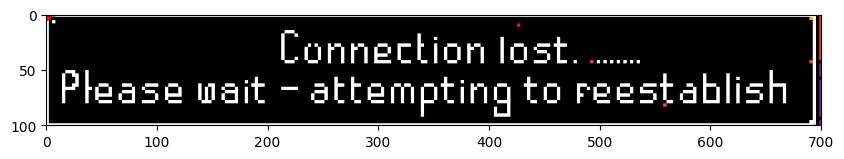

In [21]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

# mark top pixels
for (x, y) in top_pixels:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(0, 700)  # adjust 
ax.set_ylim(100, 0)
plt.show()

# Look at (0, 0) -> Connection Lost banner

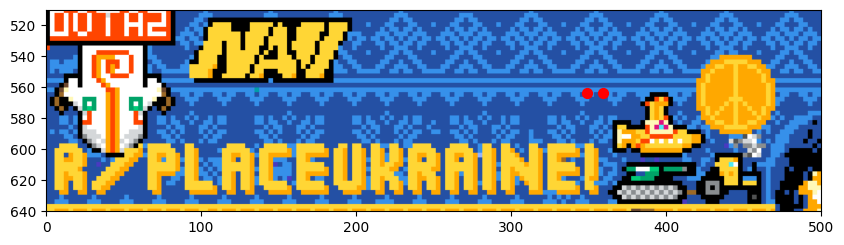

In [22]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

# mark top pixels
for (x, y) in top_pixels:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(0, 500)  # adjust 
ax.set_ylim(640, 510)
plt.show()

# Look at (359, 564) and (349, 564) -> R/PLACEUKRAINE banner

^^ do some online research on
- Connection Lost banner
    - users' response to Reddit removing their ability to place pixels 
    - were pixels on this banner painted on a lot?

- R/PLACEUKRAINE banner
    - most likely due to support for Ukraine after Russia-Ukraine war in 2022
    - were pixels on this banner painted on a lot? (just the background, blue part)

In [ ]:
# time visualization of changes on each banner?
# how did pixel color change over time
    # were people fighting over which color should be what? 
        # (0,0) seemed to be changing from black and white the most (and why orange/red color?)
        # other pixels changing from white and light blue (and why orange again?)


/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_22179/1833912536.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('color_count')


<Figure size 1200x600 with 0 Axes>

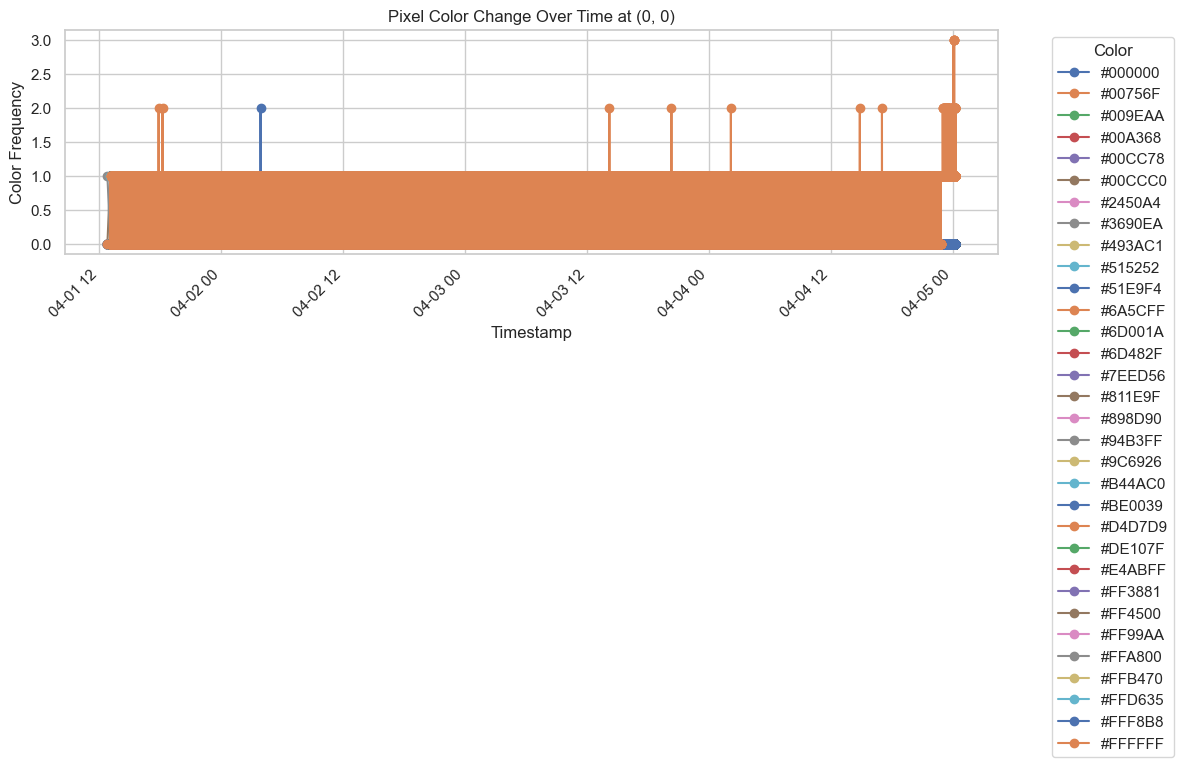

In [ ]:
import polars as pl
import matplotlib.pyplot as plt

# Filter for specific coordinates (e.g., (0, 0))
filtered_data = lf.filter((pl.col('x') == 0) & (pl.col('y') == 0))

# Group by timestamp and pixel color, then count occurrences
color_counts = filtered_data.group_by(['timestamp', 'pixel_color']).agg(
    pl.len().alias('color_count')
)

# Collect the result into a Pandas DataFrame for plotting
color_counts_df = color_counts.collect().to_pandas()

# Ensure timestamp is datetime type for plotting
color_counts_df['timestamp'] = pd.to_datetime(color_counts_df['timestamp'])

# Pivot the DataFrame so that each color becomes a column
color_counts_pivot = color_counts_df.pivot_table(index='timestamp', columns='pixel_color', values='color_count', aggfunc='sum').fillna(0)

# Plot the line graph for color frequency over time
plt.figure(figsize=(12, 6))
color_counts_pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Pixel Color Change Over Time at (0, 0)')
plt.xlabel('Timestamp')
plt.ylabel('Color Frequency')
plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_22179/2641983856.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('color_count')


<Figure size 1200x600 with 0 Axes>

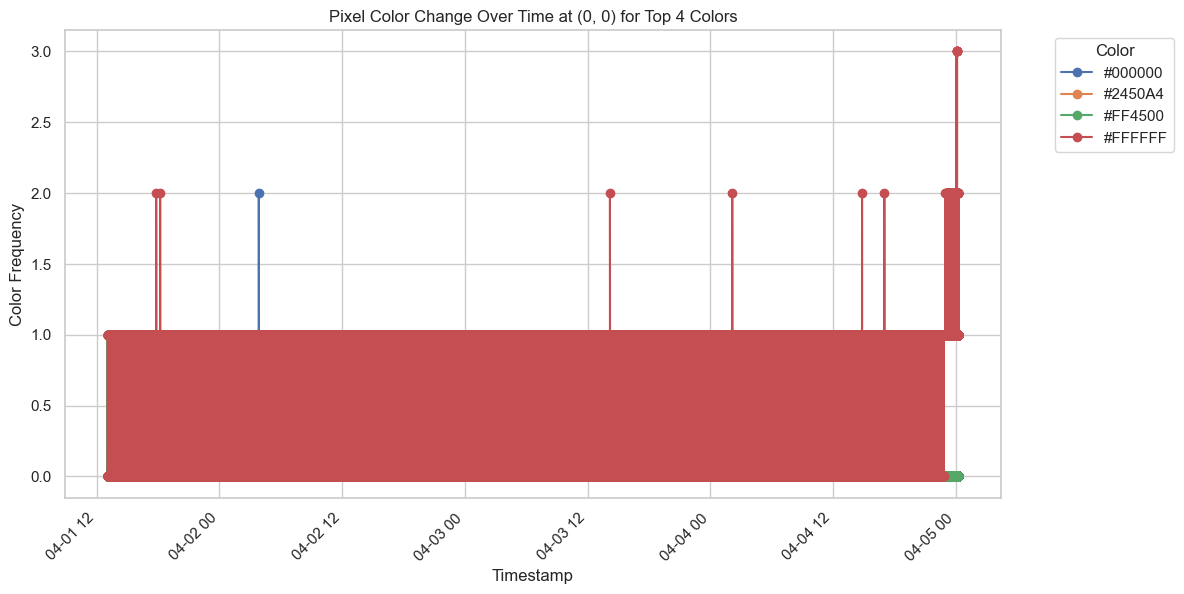

In [78]:
import polars as pl
import matplotlib.pyplot as plt

# Read the parquet file as a LazyFrame
# lf = pl.scan_parquet("your_dataset.parquet")

# Count the frequency of each color across the entire dataset
color_counts = lf.group_by('pixel_color').agg(
    pl.len().alias('color_count')
)

# Collect the result into a Pandas DataFrame
color_counts_df = color_counts.collect().to_pandas()

# Sort the colors by count in descending order and select the top 4
top_colors = color_counts_df.sort_values('color_count', ascending=False).head(4)

# Extract the top 4 color values
top_color_values = top_colors['pixel_color'].tolist()

# Filter the original LazyFrame to only include these top 4 colors
filtered_data = lf.filter(pl.col('pixel_color').is_in(top_color_values))

# For a specific pixel, e.g., (0, 0), filter by coordinates and then group by timestamp and color
filtered_data_pixel = filtered_data.filter((pl.col('x') == 0) & (pl.col('y') == 0))

# Group by timestamp and pixel color, then count occurrences
color_counts_pixel = filtered_data_pixel.group_by(['timestamp', 'pixel_color']).agg(
    pl.len().alias('color_count')
)

# Collect the result into a Pandas DataFrame for plotting
color_counts_pixel_df = color_counts_pixel.collect().to_pandas()

# Ensure timestamp is datetime type for plotting
color_counts_pixel_df['timestamp'] = pd.to_datetime(color_counts_pixel_df['timestamp'])

# Pivot the DataFrame so that each color becomes a column
color_counts_pixel_pivot = color_counts_pixel_df.pivot_table(index='timestamp', columns='pixel_color', values='color_count', aggfunc='sum').fillna(0)

# Plot the line graph for color frequency over time
plt.figure(figsize=(12, 6))
color_counts_pixel_pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Pixel Color Change Over Time at (0, 0) for Top 4 Colors')
plt.xlabel('Timestamp')
plt.ylabel('Color Frequency')
plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


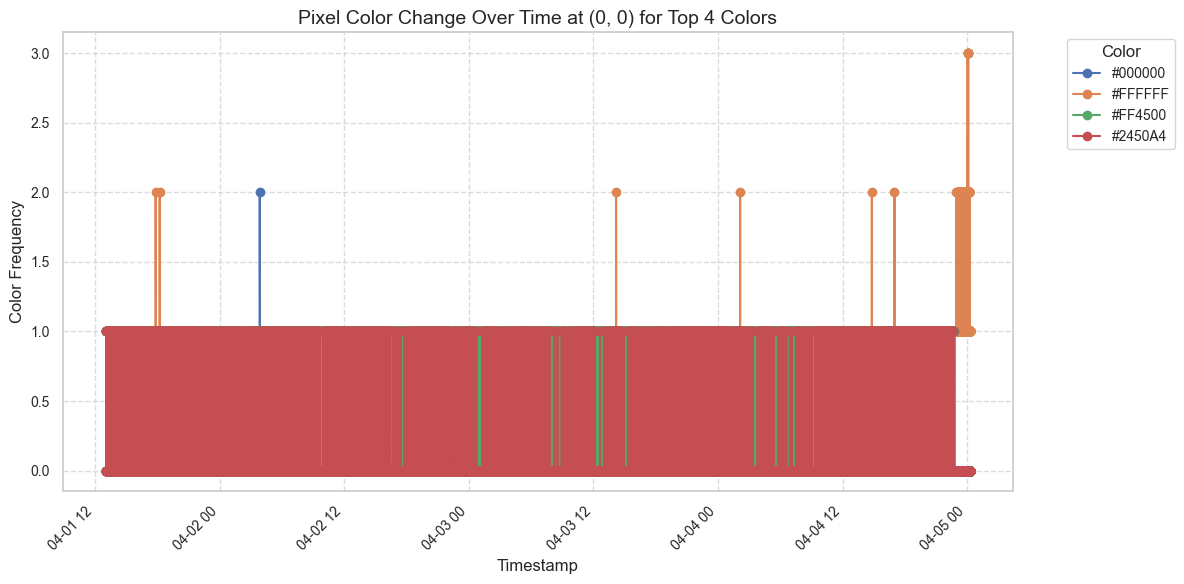

In [147]:
import polars as pl
import matplotlib.pyplot as plt

# Assuming previous code for data preparation is here...

# Step 8: Plot the data with improved readability
plt.figure(figsize=(12, 6))

# Plot each color with different line styles and markers
for color in top_color_values:
    plt.plot(
        color_counts_pixel_pivot.index, 
        color_counts_pixel_pivot[color], 
        label=color, 
        marker='o',  # Circular markers
        linestyle='-',  # Solid lines
        markersize=6  # Adjust marker size for visibility
    )

# Title and labels
plt.title('Pixel Color Change Over Time at (0, 0) for Top 4 Colors', fontsize=14)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Color Frequency', fontsize=12)

# Increase legend font size
plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Improve grid visibility and adjust tick labels
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels and adjust alignment
plt.yticks(fontsize=10)

# Tight layout to avoid overlapping labels
plt.tight_layout()

# Show plot
plt.show()


In [151]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Define the start and end of the time frame (example: from 04-01 12:00 to 04-01 18:00)
start_time_str = '2024-04-01 12:00:00'
end_time_str = '2024-04-01 18:00:00'

# Convert the strings to datetime using Python's datetime module
start_time = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime(end_time_str, '%Y-%m-%d %H:%M:%S')

# Filter the LazyFrame for the time frame
filtered_data_timeframe = lf.filter(
    (pl.col('timestamp') >= start_time) & (pl.col('timestamp') <= end_time)
)

# Define the specific pixel locations you're interested in
pixel_locations = [(0, 0), (364, 0)]  # Modify as needed with other coordinates

# Filter data for these specific pixels
filtered_data_pixels = filtered_data_timeframe.filter(
    pl.col('x').is_in([loc[0] for loc in pixel_locations]) &
    pl.col('y').is_in([loc[1] for loc in pixel_locations])
)

# Group by timestamp and pixel coordinates, then count occurrences
pixel_counts = (
    filtered_data_pixels.group_by(['timestamp', 'x', 'y'])
    .agg(pl.count().alias('count'))
)

# Collect the result into a Pandas DataFrame
pixel_counts_df = pixel_counts.collect().to_pandas()

# Ensure 'timestamp' is in datetime format
pixel_counts_df['timestamp'] = pd.to_datetime(pixel_counts_df['timestamp'])

# If you'd like to have a time series plot for specific pixels, you can pivot the data
pixel_counts_pivot = pixel_counts_df.pivot_table(
    index='timestamp', columns=['x', 'y'], values='count', aggfunc='sum', fill_value=0
)

# Plot as a time series (you can modify the columns of interest)
plt.figure(figsize=(12, 6))

for column in pixel_counts_pivot.columns:
    plt.plot(
        pixel_counts_pivot.index, 
        pixel_counts_pivot[column], 
        label=f"Pixel {column}",
        marker='o',
        linestyle='-', 
        markersize=6
    )

plt.title('Pixel Frequency in Time Frame 04-01 12:00 - 18:00')
plt.xlabel('Timestamp')
plt.ylabel('Pixel Occurrences')
plt.legend(title='Pixel Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Or, if you'd like a bar chart of total occurrences for each pixel
pixel_totals = pixel_counts_df.groupby(['x', 'y'])['count'].sum().reset_index()

plt.figure(figsize=(10, 6))
for idx, row in pixel_totals.iterrows():
    plt.bar(f"Pixel {row['x'], row['y']}", row['count'], label=f"Pixel {row['x'], row['y']}")

plt.title('Total Pixel Occurrences in Time Frame 04-01 12:00 - 18:00')
plt.xlabel('Pixel Location')
plt.ylabel('Total Occurrences')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_22179/4048669042.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('count'))


SchemaError: invalid series dtype: expected `String`, got `datetime[μs]` for series with name `timestamp`